In [3]:
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data_jobs.csv:   0%|          | 0.00/231M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/785741 [00:00<?, ? examples/s]

In [4]:
df_US = df[df['job_country'] == 'United States']

In [5]:
df_skills = df_US.explode('job_skills')

df_skills[['job_title', 'job_skills']]

job_title job_skills
0       Senior Clinical Data Engineer / Principal Clin...       None
3       LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...     python
3       LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...        c++
3       LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...       java
3       LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...     matlab
...                                                   ...        ...
785692               Data Scientist- Hybrid Work Location          r
785703            Data Analyst - CRYPTOGRAPHY - Full-time       None
785705          Expert Business Data Analyst - Now Hiring        sql
785705          Expert Business Data Analyst - Now Hiring     python
785705          Expert Business Data Analyst - Now Hiring    tableau

[1073565 rows x 2 columns]

In [6]:
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()


df_skills_count = df_skills_count.reset_index(name='skill_count')

df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

job_skills            job_title_short  skill_count
1209     python             Data Scientist        42379
1521        sql               Data Analyst        34452
1523        sql             Data Scientist        30034
455       excel               Data Analyst        27519
1243          r             Data Scientist        26022
...         ...                        ...          ...
1785     vue.js           Business Analyst            1
60         arch           Business Analyst            1
71        asana  Machine Learning Engineer            1
968      no-sql  Machine Learning Engineer            1
1861       zoom             Cloud Engineer            1

[1870 rows x 3 columns]

In [7]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

In [8]:
fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)[::-1]
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 45000) # make the scales the same

fig.suptitle('Counts of Skills Requested in US Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5) # fix the overlap
plt.show()

In [9]:
df_job_title_count = df_US['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

job_title_short  jobs_total
0               Data Analyst       67816
1             Data Scientist       58830
2              Data Engineer       35080
3      Senior Data Scientist       12946
4        Senior Data Analyst       11791
5       Senior Data Engineer        9289
6           Business Analyst        7382
7          Software Engineer        1814
8  Machine Learning Engineer         921
9             Cloud Engineer         423

In [10]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left')

df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100

df_skills_perc

job_skills            job_title_short  skill_count  jobs_total  \
0        python             Data Scientist        42379       58830   
1           sql               Data Analyst        34452       67816   
2           sql             Data Scientist        30034       58830   
3         excel               Data Analyst        27519       67816   
4             r             Data Scientist        26022       58830   
...         ...                        ...          ...         ...   
1865     vue.js           Business Analyst            1        7382   
1866       arch           Business Analyst            1        7382   
1867      asana  Machine Learning Engineer            1         921   
1868     no-sql  Machine Learning Engineer            1         921   
1869       zoom             Cloud Engineer            1         423   

      skill_percent  
0         72.036376  
1         50.802171  
2         51.052184  
3         40.578919  
4         44.232534  
...             ...  
1865       0.013546  
1866       0.013546  
1867       0.108578  
1868       0.108578  
1869       0.236407  

[1870 rows x 5 columns]

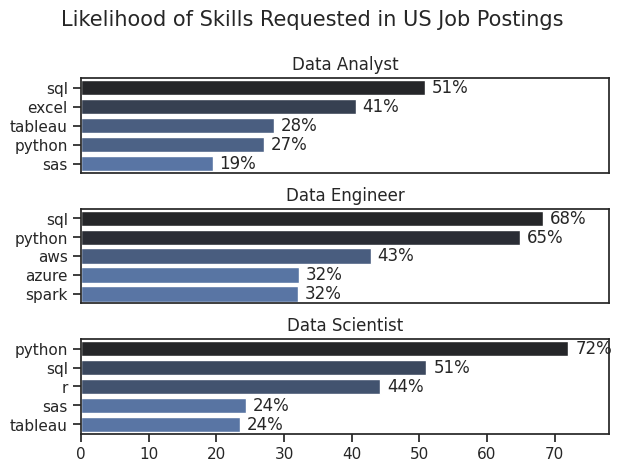

In [11]:
fig, ax = plt.subplots(len(job_titles), 1)


for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 78)
    # remove the x-axis tick labels for better readability
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    # label the percentage on the bars
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in US Job Postings', fontsize=15)
fig.tight_layout(h_pad=.8)
plt.show()